# [Kaggle Link](https://www.kaggle.com/competitions)

# Prep

In [1]:
dependencies = [
    "kagtool",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "kaggle",
    "fastai",
    "datasets",
    "evaluate",
    "accelerate",
    "protobuf"
]

!pip install -U {" ".join(dependencies)}

In [ ]:
from kagtool.datasets.kaggle_downloader import KaggleDownloader

dataset_name = 'titanic'
# add your username and key here!
creds = '{"username":"","key":""}'

dataset_path = KaggleDownloader(dataset_name, creds).load_or_fetch_kaggle_dataset()

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from fastai.imports import *
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch
from torch import tensor


np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Expectations

Expected format:
- Headers
- PassengerId [int]
- Survived [0, 1]
- No more no less!

Metric = accuracy

- https://youtu.be/_rXzeWq4C6w?si=OQTFeZApNwujO0Vp&t=1763


# Plan

1. Understand the dataset, put yourself in the head of the customer of your model
1. Take a sample of the dataset
1. Get an idea of the problem + EDA, get a feel of what is clear and what is not (what will pose pb later?)
1. Quick and dirt clean (keep notes of what u did though we will need to fix later)
1. Turn the problem into a pattern we solved before
1. Get a baseline result
1. Come back to preprocessing and do feature engineering

# EDA

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def unique_and_dups(col):
    uniqs = col.nunique() / len(col) * 100,
    dups = (col.duplicated().sum() / len(col)) * 100
    print(uniqs, dups)

def plot_text_length(df, col):
    df['text_length'] = df[col].apply(len)
    length_counts = df['text_length'].value_counts().sort_index(ascending=True)

    length_counts.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.title('Breakdown of Text Lengths')
    plt.show()

def display_text_examples_by_length(df, col):
    # Step 1: Find the minimum, maximum, and medium length of the text
    min_length = df[col].str.len().min()
    max_length = df[col].str.len().max()
    medium_length = df[col].str.len().median()

    # Step 2: Filter the DataFrame to include only the rows with the desired lengths
    min_length_rows = df[df[col].str.len() == min_length]
    max_length_rows = df[df[col].str.len() == max_length]
    medium_length_rows = df[df[col].str.len() == medium_length]

    # Step 3: Display the filtered DataFrame
    print("Examples of minimum length text:", min_length)
    print(min_length_rows[col].tolist()[:5])
    print("\nExamples of maximum length text:", max_length)
    print(max_length_rows[col].tolist()[:5])
    print("\nExamples of medium length text:", medium_length)
    print(medium_length_rows[col].tolist()[:5])

In [5]:
df = pd.read_csv(dataset_path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


__Categories__
- SibSp = number of siblings / spouses aboard the titanic
- Parch = number of parents / children abord the titatnic
- Embarked = Port of Embarkation

__Hypothesis__:
- Does it help to have people aboard with you or not?
- Embarked: tell us about social class? Does social class help with survival?
- Ticket class: tell us about social class?
- Ticket Fare: also tell us about social class? But also about how many ppl aboard with them maybe, if it's bigger room
- Age: Children were prioritized for boats
- Gender: Female were also prioritez for boats

__Good to know__:
- Titatnic had 2224 passengers, we got 891 rows (40% of the passengers list)
- 67% of people died
- How many boats could the titanic carry?
- Look at distrib of social classes 
- How many men or women aboard?
- Distrib by age
- Where do people come from mainly? Which Port (onyl 3 ports Cherbourg, Queenstown, Southampton)

__Technique__:
- How many NA
- Which column has smallest range
- Which column has biggest range
- What are the categorical variables
- What can I learn about text columns
- Who is the most common person, who is the least common

### Missing Values

It's important not to just blindly fill the column, but also take note of what columns are missing the most

In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df.Cabin.isna().sum() / len(df)

0.7710437710437711

For almost everyone we dunno whats their cabin!!! We shouldn't drop this column, but keep in mind that this column is not that important.

### Common Values

In [8]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

### Fix NA

In [9]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


<Axes: >

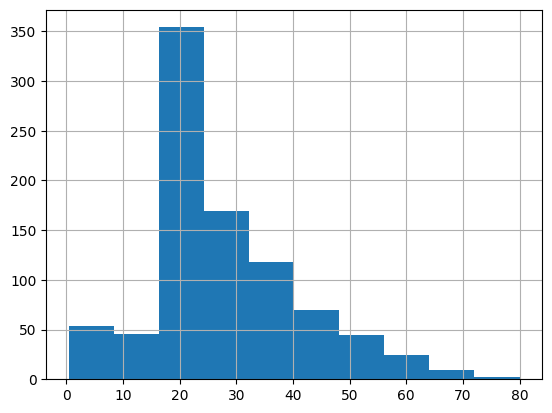

In [12]:
df.Age.hist()

<Axes: >

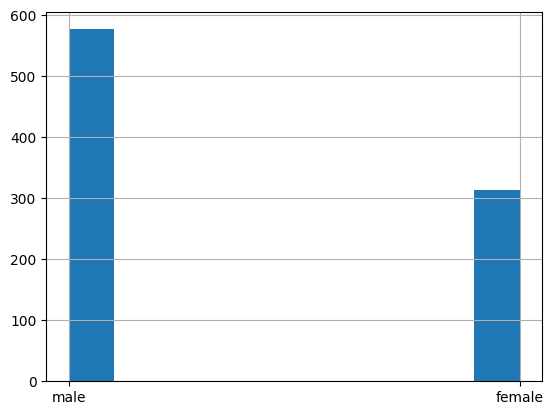

In [13]:
df.Sex.hist()

<Axes: >

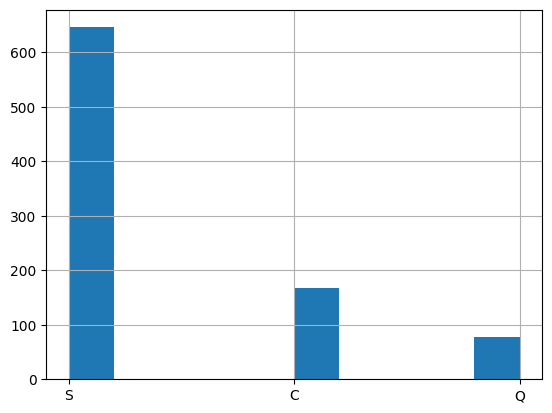

In [14]:
df.Embarked.hist()

### Create a persona for X
- around 18 and 24
- Male (2/3 of passengers were male)
- Embarked at S

 ### What does the ideal Persona for Y look like?

In [15]:
survived_df = df[df.Survived == 1]
survived_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,342.000000,342.0,342.000000,342.000000,342.000000,342.000000,342.000000
mean,444.368421,1.0,1.950292,27.683246,0.473684,0.464912,48.395408
std,252.358840,0.0,0.863321,13.852214,0.708688,0.771712,66.596998
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,250.750000,1.0,1.000000,21.000000,0.000000,0.000000,12.475000
50%,439.500000,1.0,2.000000,25.000000,0.000000,0.000000,26.000000
75%,651.500000,1.0,3.000000,35.000000,1.000000,1.000000,57.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


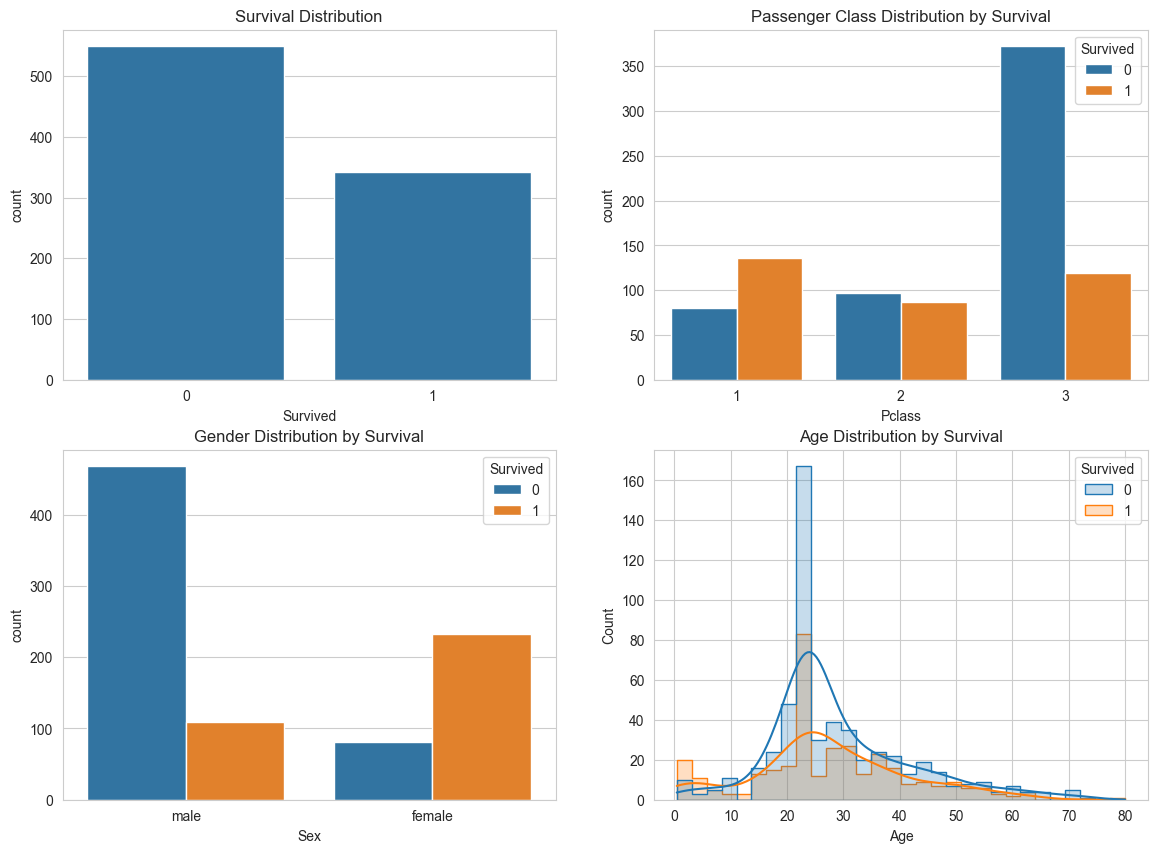

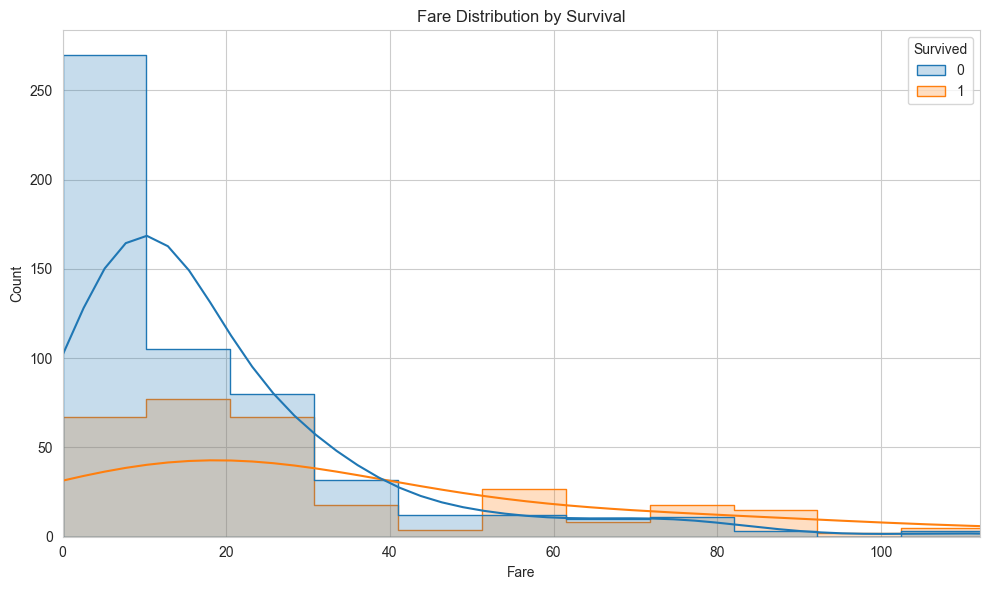

In [16]:
#Set the aesthetic style of the plots
sns.set_style("whitegrid")

#Initialize the figure
plt.figure(figsize=(14, 10))

#Plot distribution of key variables
plt.subplot(2, 2, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Passenger Class Distribution by Survival')

plt.subplot(2, 2, 3)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Gender Distribution by Survival')

plt.subplot(2, 2, 4)
sns.histplot(x='Age', hue='Survived', data=df, kde=True, element='step', bins=30)
plt.title('Age Distribution by Survival')


plt.figure(figsize=(10, 6))
sns.histplot(x='Fare', hue='Survived', data=df, kde=True, element='step', bins=50)
plt.title('Fare Distribution by Survival')
plt.xlim(0, df['Fare'].quantile(0.95))  # Limiting to 95th percentile for better visualization

plt.tight_layout()
plt.show()

This plot means that the lowest the fare, the biggest difference in survival!

# Fixes
1. fix na with modes
1. categorize text
1. normalize

### Turning Texts into Categories (Categorify)

In [17]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [18]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

### Normalize

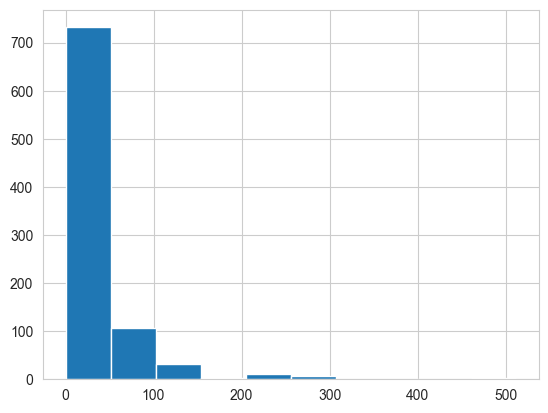

In [19]:
df['Fare'].hist();

In [20]:
# log(0) is infinite -- to fix this, we'll simply add 1 to all values first:
df['LogFare'] = np.log(df['Fare']+1)

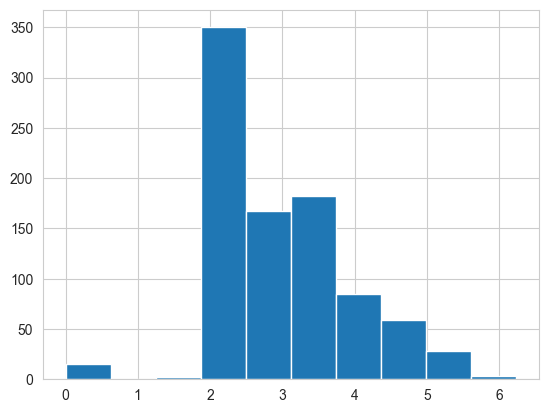

In [21]:
df['LogFare'].hist();

# How to solve this?

The first question to ask yourselves, is what do our model need to do?
How will the customer use our model?

In [22]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


For a given row, we will be given columns, and we need to predict the Survived column.

Given some independant variables we need to calculate the dependant variables.

So, we got a an equation that looks like:
- PassengerId*a, Pclass*b, Name*c = y

If we consider independant variables as a matrix or tensor, we got a tensor equation:
- ax + b = y

This is a linear regression model!
- We know a, these will be the row value
- We need to figure out the rest

For a given row, if we know how important each independant variable, if we can calculate coefficients for each column.

Think as a mayor trying to create a road for a village. The village has houses everywhere, and we need to create a house that will fit as many houses as possible.

The thing is, we are blind, so we need indicators, to tell us:
- from km1 to km5: go 0.5% on the left
- from km5 to km10: go 3% on the right
- etc

These are our coefficients that shapes our road, and if we follow the road, we will find out the answer to the dependant variable Y


# Exploring how a Linear Model Works

### Setup Independant and Dependant Variables

In [23]:
t_dep = tensor(df.Survived)
t_dep.shape, t_dep[:10]

(torch.Size([891]), tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

In [24]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'LogFare'],
      dtype='object')

In [25]:
indep_cols = np.array(['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male'], dtype=object)
t_indep = tensor(df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
t_indep.shape, t_indep[:10]


(torch.Size([891, 12]),
 tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
         [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000],
         [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000],
         [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
         [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 2.0000,  3.0000,  1.0000,  3.0944,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [27.0000,  0.00

### Weights

In [26]:
# torch.manual_seed(442)

In [27]:
# how many columns do we have?
n_coeff = t_indep.shape[1]

# we want to center values around 0
adjust = 0.5

# why rand and not randn?
coeffs = torch.rand(n_coeff) - adjust
coeffs

tensor([ 0.0263,  0.0724,  0.4850, -0.1683,  0.3501, -0.4371, -0.1568,  0.4386,  0.0237, -0.4449, -0.4952,  0.1270])

For each row of the table, we need to multiply each column by a coeff, we can do that with broadcasting (or not). We are just doing element wise multipltication, each column will be multiplied by their own coeffs

In [28]:
t_indep*coeffs

tensor([[ 0.5788,  0.0724,  0.0000, -0.3551,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 0.9997,  0.0724,  0.0000, -0.7202,  0.3501, -0.0000, -0.0000,  0.4386,  0.0000, -0.0000, -0.4952,  0.0000],
        [ 0.6840,  0.0000,  0.0000, -0.3683,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.4952,  0.0000],
        [ 0.9208,  0.0724,  0.0000, -0.6715,  0.3501, -0.0000, -0.0000,  0.0000,  0.0000, -0.4449, -0.4952,  0.0000],
        [ 0.9208,  0.0000,  0.0000, -0.3706,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 0.6314,  0.0000,  0.0000, -0.3781,  0.0000, -0.0000, -0.1568,  0.0000,  0.0237, -0.0000, -0.0000,  0.1270],
        [ 1.4206,  0.0000,  0.0000, -0.6676,  0.3501, -0.0000, -0.0000,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        ...,
        [ 0.6577,  0.0000,  0.0000, -0.3509,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 1.0260,  0.0000,  2.4251, -0.5730

### Check for Normalization issues

__Which column is unbalanced, which column has the worst standard deviation__

In [29]:
t_indep.shape

torch.Size([891, 12])

In [30]:
# Calculate the standard deviation for each column
std_devs = torch.std(t_indep, dim=0)
std_devs

tensor([13.1996,  1.1027,  0.8061,  0.9690,  0.4288,  0.4050,  0.4977,  0.3914,  0.2811,  0.4468,  0.4780,  0.4780])

In [31]:
# Find the column with the maximum standard deviation
max_std_dev_column = torch.argmax(std_devs)

print("Column", max_std_dev_column.item(), "influences the standard deviation the most.")

Column 0 influences the standard deviation the most.


We want to divide each val by its maximum value so that every columns have a similar range, otherwise as we can see the first column will have a much bigger range than other column

In [32]:
vals,indices = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [33]:
t_indep = t_indep / vals
t_indep * coeffs

tensor([[ 0.0072,  0.0090,  0.0000, -0.0569,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 0.0125,  0.0090,  0.0000, -0.1154,  0.3501, -0.0000, -0.0000,  0.4386,  0.0000, -0.0000, -0.4952,  0.0000],
        [ 0.0086,  0.0000,  0.0000, -0.0590,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.4952,  0.0000],
        [ 0.0115,  0.0090,  0.0000, -0.1076,  0.3501, -0.0000, -0.0000,  0.0000,  0.0000, -0.4449, -0.4952,  0.0000],
        [ 0.0115,  0.0000,  0.0000, -0.0594,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 0.0079,  0.0000,  0.0000, -0.0606,  0.0000, -0.0000, -0.1568,  0.0000,  0.0237, -0.0000, -0.0000,  0.1270],
        [ 0.0178,  0.0000,  0.0000, -0.1070,  0.3501, -0.0000, -0.0000,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        ...,
        [ 0.0082,  0.0000,  0.0000, -0.0562,  0.0000, -0.0000, -0.1568,  0.0000,  0.0000, -0.4449, -0.0000,  0.1270],
        [ 0.0128,  0.0000,  0.4042, -0.0918

In [34]:
torch.std(t_indep, dim=0)

tensor([0.1650, 0.1378, 0.1343, 0.1553, 0.4288, 0.4050, 0.4977, 0.3914, 0.2811, 0.4468, 0.4780, 0.4780])

much better!

### First Loss

For each ROW (axis=1), we calculate a survival rate

In [35]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([-0.5153,  0.1996, -1.1474, -0.6771, -0.5226, -0.0588, -0.0571, -0.4495, -0.9937, -0.5727])

We compare our predictions to the actual values

In [36]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.9197)

Cool... we got a 83% rate of error!! Of course, we haven't done anything than multiptly each column by garbage random coeffs.

HOWEVER! By being able to compare what we have to actual survival rate, we will be able to know how far we are from the actual target, and adjust the help of gradients, on to next stage: gradient descent!

In [37]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### Gradient Descent

In [38]:
coeffs.requires_grad_()

tensor([ 0.0263,  0.0724,  0.4850, -0.1683,  0.3501, -0.4371, -0.1568,  0.4386,  0.0237, -0.4449, -0.4952,  0.1270], requires_grad=True)

In [39]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.9197, grad_fn=<MeanBackward0>)

Magic thing that give us gradients: this creates compasses for every steps (differential operations) that we took:

In [40]:
loss.backward()

Look at the compaces:

In [41]:
coeffs.grad

tensor([-0.2822, -0.0542, -0.0527, -0.3828, -0.1571, -0.1886, -0.4658, -0.0382, -0.0730, -0.7003, -0.3502, -0.4613])

Let's try the above step again, let's do another descent!

In [42]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.5645, -0.1083, -0.1055, -0.7655, -0.3143, -0.3771, -0.9315, -0.0763, -0.1459, -1.4007, -0.7003, -0.9226])

We should not accumulate gradients so we should reset at each descent!

In [43]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.6174)


Let's do this multiple times

In [44]:
for i in range(0, 10):
    loss = calc_loss(coeffs, t_indep, t_dep)
    loss.backward()
    with torch.no_grad():
        coeffs.sub_(coeffs.grad * 0.1)
        coeffs.grad.zero_()
        print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5937)
tensor(0.5726)
tensor(0.5520)
tensor(0.5340)
tensor(0.5104)
tensor(0.4877)
tensor(0.4678)
tensor(0.4506)
tensor(0.4354)
tensor(0.4137)


It's improving! Meaning loss is descreasing and we are getting closer to our target Y

# Getting Real - Training a Linear Model

### Summary of our Preprocess

In [45]:
def preprocess_df_into_indeps_vars(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)


    df['LogFare'] = np.log(df['Fare']+1)
    df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])

    indep_cols = np.array(['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male'], dtype=object)
    indeps = tensor(df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
    indeps = indeps / vals
    return indeps


### Validation Set

Before training a model, we should should make sure to hold a validation set.
The validation set is here to help us see how well the model generalizes with unseen data. We will use a metric to calculate this.

But first, let's decide how to split the validation set. The data is not time sensitive, every rows are independant, so we can safely do a rand. (we can revisit later if there's a better split when iterating)

In [46]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [47]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

### Metric

We need a way to calculate how well the model is doing its job. The cost function was used to help the model converge, but we still need a way to calculate the quality of the model, especially on a unseen data.

First we need to apply the model to new unseen rows

In [48]:
# NOTE THE USE OF VAL_INDEP THIS TIME INSTEAD OF T_INDEP
preds = calc_preds(coeffs, val_indep)
preds[:10]

tensor([-0.1691,  0.1243,  0.5115, -0.1028, -0.0998, -0.0685,  0.3875, -0.2711,  0.2153,  0.4392], grad_fn=<SliceBackward0>)

Then we compare the results to the actual Y (the Survived columns), this is how we get a tensor that represent the Survived column

In [49]:
val_dep

tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1])

The competition says that a score 0 = death, 1 = survival.
So we need to make our values converge to either 0 or 1.

Let's use panda to take a look at our predictions (proposed Survival rate) for each rows

In [50]:
preds_df = pd.DataFrame(preds)
preds_df.describe()


,0
count,178.000000
mean,0.188576
std,0.341869
min,-0.285073
25%,-0.051550
50%,0.031067
75%,0.437913
max,1.188872


We got negative, values, that's not what we want, we want to make the predictions converge to either 0 or 1, we can use a squashing function like sigmoid to do that.

 To fix this, we should pass every prediction through the sigmoid function, which has a minimum at zero and maximum at one, and is defined as follows:

In [51]:
# previous this is how we defined our Survived result
# survival_rate = (coeffs * val_indep).sum(axis=1)

# We now use sigmoid to make the rate converge to either 0 or 1
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

# let's check the first 10 rows
calc_preds(coeffs, val_indep)[:10]

tensor([0.4578, 0.5310, 0.6252, 0.4743, 0.4751, 0.4829, 0.5957, 0.4326, 0.5536, 0.6081], grad_fn=<SliceBackward0>)

In [52]:
preds_df = pd.DataFrame(calc_preds(coeffs, val_indep))
preds_df.describe()

,0
count,178.000000
mean,0.544978
std,0.081224
min,0.429210
25%,0.487115
50%,0.507766
75%,0.607761
max,0.766539


we got rid of negative values, std is much lower as well

We can now define our accuracy metric, we will consider that over 0.5 means survived

In [53]:
def acc(w):
     with torch.no_grad():
        return (val_dep.bool()==(calc_preds(w, val_indep)>0.5)).float().mean()

### Trainer Steps

Training a model consists of 2 steps:
1. init coeffs
2. run the optimizer (gradient descent)

The optimizer does 4 things:
1. calculate loss
2. calculate gradients
3. update coeffs according to gradients
4. rinse and repeat

In [54]:
def gradient_descent(coeffs, epochs, lr, trn_indep, trn_dep):
    for i in range(epochs):
        loss = calc_loss(coeffs, trn_indep, trn_dep)

        # calc gradients
        loss.backward()
        with torch.no_grad():
            # update coeffs
            coeffs.sub_(coeffs.grad * lr)
            coeffs.grad.zero_()
        print(f'Epoch {i+1}: {loss.item()}')

def init_coeffs(): return torch.rand(n_coeff).requires_grad_()

def train_model(epochs, lr, trn_indep, trn_dep):
    coeffs = init_coeffs()
    gradient_descent(coeffs, epochs, lr, trn_indep, trn_dep)
    return coeffs

In [55]:
trained_coeffs = train_model(18, lr=100, trn_indep=trn_indep, trn_dep=trn_dep)

Epoch 1: 0.581784725189209
Epoch 2: 0.2844052016735077
Epoch 3: 0.25080952048301697
Epoch 4: 0.21009407937526703
Epoch 5: 0.20616939663887024
Epoch 6: 0.20375148952007294
Epoch 7: 0.20207370817661285
Epoch 8: 0.20085595548152924
Epoch 9: 0.19993411004543304
Epoch 10: 0.19921398162841797
Epoch 11: 0.19863606989383698
Epoch 12: 0.19816216826438904
Epoch 13: 0.19776633381843567
Epoch 14: 0.19743044674396515
Epoch 15: 0.1971413493156433
Epoch 16: 0.19688935577869415
Epoch 17: 0.19666725397109985
Epoch 18: 0.19646961987018585


Let's take a look at the coeffs

In [56]:
def show_coeffs(coeffs): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs(trained_coeffs)

{'Age': tensor(-0.8275),
 'SibSp': tensor(-1.0359),
 'Parch': tensor(-0.4203),
 'LogFare': tensor(0.1073),
 'Pclass_1': tensor(2.3856),
 'Pclass_2': tensor(2.1970),
 'Pclass_3': tensor(-4.6326),
 'Embarked_C': tensor(0.9096),
 'Embarked_Q': tensor(1.7729),
 'Embarked_S': tensor(-3.5983),
 'Sex_female': tensor(6.3650),
 'Sex_male': tensor(-6.5438)}

Cool, but it doesn't tell us how accurate the model is, let's check the metric

In [57]:
acc(trained_coeffs)

tensor(0.8258)

That's bad, let's keep looping and keep an eye on the accuracy to see if it's improving, we gonna modify our train model thing

In [58]:
def update_coeffs(coeffs, lr):
    with torch.no_grad():
        # update coeffs
        coeffs.sub_(coeffs.grad * lr)
        coeffs.grad.zero_()
    return coeffs


def gradient_descent(coeffs, epochs, lr, trn_indep, trn_dep):
    for i in range(epochs):
        loss = calc_loss(coeffs, trn_indep, trn_dep)

        # calc gradients
        loss.backward()
        coeffs = update_coeffs(coeffs, lr)
        print(f'Epoch {i+1}: {loss.item()}, Accuracy: {acc(coeffs)}')

In [59]:
trained_coeffs = train_model(18, lr=100, trn_indep=trn_indep, trn_dep=trn_dep)
show_coeffs(trained_coeffs)

Epoch 1: 0.6054569482803345, Accuracy: 0.7921348214149475
Epoch 2: 0.2609129250049591, Accuracy: 0.7584269642829895
Epoch 3: 0.2607482969760895, Accuracy: 0.7921348214149475
Epoch 4: 0.22707444429397583, Accuracy: 0.7921348214149475
Epoch 5: 0.2153661847114563, Accuracy: 0.7921348214149475
Epoch 6: 0.21518635749816895, Accuracy: 0.7921348214149475
Epoch 7: 0.21505437791347504, Accuracy: 0.7921348214149475
Epoch 8: 0.21494683623313904, Accuracy: 0.7921348214149475
Epoch 9: 0.21485094726085663, Accuracy: 0.7921348214149475
Epoch 10: 0.2147577852010727, Accuracy: 0.7921348214149475
Epoch 11: 0.2146594077348709, Accuracy: 0.7921348214149475
Epoch 12: 0.21454623341560364, Accuracy: 0.7921348214149475
Epoch 13: 0.21440407633781433, Accuracy: 0.7921348214149475
Epoch 14: 0.21420787274837494, Accuracy: 0.7921348214149475
Epoch 15: 0.21390628814697266, Accuracy: 0.7921348214149475
Epoch 16: 0.21337851881980896, Accuracy: 0.7921348214149475
Epoch 17: 0.21229328215122223, Accuracy: 0.792134821414

{'Age': tensor(-0.6256),
 'SibSp': tensor(-0.3271),
 'Parch': tensor(0.1810),
 'LogFare': tensor(0.0775),
 'Pclass_1': tensor(1.1601),
 'Pclass_2': tensor(0.7671),
 'Pclass_3': tensor(-3.5216),
 'Embarked_C': tensor(0.2967),
 'Embarked_Q': tensor(0.6599),
 'Embarked_S': tensor(-2.3145),
 'Sex_female': tensor(5.5401),
 'Sex_male': tensor(-6.5341)}

Let's sort this to see what are the biggest factors influencing if sopmeone survived or not

In [60]:
sorted(dict(zip(indep_cols, trained_coeffs.requires_grad_(False))).items(), key=lambda x: x[1])

[('Sex_male', tensor(-6.5341)),
 ('Pclass_3', tensor(-3.5216)),
 ('Embarked_S', tensor(-2.3145)),
 ('Age', tensor(-0.6256)),
 ('SibSp', tensor(-0.3271)),
 ('LogFare', tensor(0.0775)),
 ('Parch', tensor(0.1810)),
 ('Embarked_C', tensor(0.2967)),
 ('Embarked_Q', tensor(0.6599)),
 ('Pclass_2', tensor(0.7671)),
 ('Pclass_1', tensor(1.1601)),
 ('Sex_female', tensor(5.5401))]

It seems to match what our analysis said, people with lower social eco, were more likely to die while female and better class were more likely to survive!

# Kaggle - Linear Model

In [61]:
def create_kaggle_submission(trained_coeffs):
    tst_df = pd.read_csv(dataset_path/'test.csv')

    tst_indep = preprocess_df_into_indeps_vars(tst_df)

    tst_df['Survived'] = (calc_preds(trained_coeffs, tst_indep)>0.5).int()

    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv('sub.csv', index=False)

    !head sub.csv

create_kaggle_submission(trained_coeffs)

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


# Refactor with Matrix Product

Take a look at the inner-most calculation we're doing to get the predictions:

In [62]:
preds = (val_indep*coeffs).sum(axis=1)
preds[:10]

tensor([-0.1691,  0.1243,  0.5115, -0.1028, -0.0998, -0.0685,  0.3875, -0.2711,  0.2153,  0.4392], grad_fn=<SliceBackward0>)

Multiplying elements together + adding accross rows is the same as a matrix-vector product!

In [63]:
m = val_indep@coeffs
m[:10]

tensor([-0.1691,  0.1243,  0.5115, -0.1028, -0.0998, -0.0685,  0.3875, -0.2711,  0.2153,  0.4392], grad_fn=<SliceBackward0>)

Matrix products are very highly optimized so let's use that. Let's refactor our functions:

In [64]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn coeffs into a column vector

In [65]:
# instead of torch.rand(n_coeff)
# we can do instead of torch.rand(n_coeff, 1)
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

torch.rand(n_coeff).shape, torch.rand(n_coeff, 1).shape 

(torch.Size([12]), torch.Size([12, 1]))

We'll also need to turn our DEPENDENT variable into a column vector

In [66]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]
# [:,None] or .reshape(-1, 1)
trn_dep.shape, val_dep.shape

(torch.Size([713, 1]), torch.Size([178, 1]))

Verify that our code still works

In [67]:
trained_coeffs = train_model(18, lr=100, trn_indep=trn_indep, trn_dep=trn_dep)

Epoch 1: 0.5095505714416504, Accuracy: 0.6797752976417542
Epoch 2: 0.3235969841480255, Accuracy: 0.6966292262077332
Epoch 3: 0.2973741292953491, Accuracy: 0.8089887499809265
Epoch 4: 0.2075757533311844, Accuracy: 0.8258426785469055
Epoch 5: 0.20052193105220795, Accuracy: 0.8258426785469055
Epoch 6: 0.1982487589120865, Accuracy: 0.8258426785469055
Epoch 7: 0.19731980562210083, Accuracy: 0.8258426785469055
Epoch 8: 0.19667822122573853, Accuracy: 0.8258426785469055
Epoch 9: 0.19620947539806366, Accuracy: 0.8258426785469055
Epoch 10: 0.19585052132606506, Accuracy: 0.8258426785469055
Epoch 11: 0.19556474685668945, Accuracy: 0.8258426785469055
Epoch 12: 0.19533006846904755, Accuracy: 0.8258426785469055
Epoch 13: 0.19513258337974548, Accuracy: 0.8258426785469055
Epoch 14: 0.1949632167816162, Accuracy: 0.8258426785469055
Epoch 15: 0.19481566548347473, Accuracy: 0.8258426785469055
Epoch 16: 0.19468556344509125, Accuracy: 0.8258426785469055
Epoch 17: 0.1945696920156479, Accuracy: 0.8258426785469

# A Neural Net

We don't use initialization and normalization technique for our weights so we manually have some hard coded value to help us center the weights, for this to work and get same results as jeremy using these hard coded adjustement values, we need to use the same torch seed

In [68]:
torch.manual_seed(442)

In [69]:
# Why did we need the matrix multiply? Can't we do a neural net with broadcasting?

Instead of having one coeff per column we gonna have 20 coeff per column

so n_cols * n_hidden

For each column instead of having one coefficient, we gonna have 20 coeff, so that's 12x20.

Imagine each column having a series of 20 pumps behind

In [70]:
n_hidden = 20
center_adjust = -0.5
layer1 = (torch.rand(n_coeff, n_hidden) + center_adjust) / n_hidden
layer1.shape

torch.Size([12, 20])

Why do we need to divide by n_hidden? Let's see why

In [71]:
layer1_without_normalizing = (torch.rand(n_coeff, n_hidden) + center_adjust) 
layer1 = (torch.rand(n_coeff, n_hidden) + center_adjust) / n_hidden
layer1_without_normalizing.std(), layer1.std()

(tensor(0.2878), tensor(0.0142))

For the second layer, what shape do we want? Think of matrix as a transformation of dimension.
- We take as input (first dim) the last dim of previous layer
- As output we should have one column

In [72]:
# # jeremy said that  the -0.3 came from trial and error
layer2_center_adjust = -0.3

layer2 = (torch.rand(n_hidden, 1) + layer2_center_adjust)
layer2.shape

torch.Size([20, 1])

Why don't we need to normalize here?
 ```
 (torch.rand(n_hidden, 1) + layer2_center_adjust) / n_hidden
```

In [73]:
# usualyl we also need a constant term for layer 1, but as we said earlier we covered every possible rows
# we have n columns instead of n-1 columns so layer 1 is fine

def init_weights(n_coeff, n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden

    # however for layer 2 the number of variables here != columns, so we need an intercept/bias term again
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [74]:
import torch.nn.functional as F

def calc_preds(w, indeps):
    l1, l2, const = w
    # we plug our table into layer 1
    # we plug multiply each column of each row by 20 weights
    # we do a ReLU on it because??
    res = F.relu(indeps@l1)
    # For each column, of each row, filter out their (12cols *20) weights into ones to get the Y (SurvivalRate)
    res = res@l2 + const
    return torch.sigmoid(res)


In [75]:
def calc_loss(w, indeps, deps): return torch.abs(calc_preds(w, indeps)-deps).mean()

In [76]:
def update_weights(w, lr):
    for layer in w:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def one_epoch(epoch_idx, lr, trn_indep, trn_dep, w):
    loss = calc_loss(w, indeps=trn_indep, deps=trn_dep)
    loss.backward()
    with torch.no_grad():
        update_weights(w, lr)
    print(f'Epoch {epoch_idx+1}: {loss.item()}, Accuracy: {acc(w)}')

def sgd(epochs, lr, trn_indep, trn_dep, w):
    for epoch_idx in range(epochs):
        one_epoch(epoch_idx, lr, trn_indep, trn_dep, w)


def train_neural_net(epochs, lr, trn_indep, trn_dep):
    torch.manual_seed(442)
    n_coeff = trn_indep.shape[1]
    w = init_weights(n_coeff)
    sgd(epochs, lr, trn_indep, trn_dep, w)
    return w

In [77]:
trained_coeffs = train_neural_net(18, lr=20, trn_indep=trn_indep, trn_dep=trn_dep)
create_kaggle_submission(trained_coeffs)

Epoch 1: 0.5441367030143738, Accuracy: 0.7865168452262878
Epoch 2: 0.4160270094871521, Accuracy: 0.7022472023963928
Epoch 3: 0.2861539423465729, Accuracy: 0.6853932738304138
Epoch 4: 0.38368409872055054, Accuracy: 0.7921348214149475
Epoch 5: 0.22075077891349792, Accuracy: 0.7921348214149475
Epoch 6: 0.20969177782535553, Accuracy: 0.8258426785469055
Epoch 7: 0.19649018347263336, Accuracy: 0.8258426785469055
Epoch 8: 0.19449244439601898, Accuracy: 0.8258426785469055
Epoch 9: 0.19379691779613495, Accuracy: 0.8258426785469055
Epoch 10: 0.19339023530483246, Accuracy: 0.8258426785469055
Epoch 11: 0.19317100942134857, Accuracy: 0.8258426785469055
Epoch 12: 0.19302920997142792, Accuracy: 0.8258426785469055
Epoch 13: 0.19292403757572174, Accuracy: 0.8258426785469055
Epoch 14: 0.1928444653749466, Accuracy: 0.8258426785469055
Epoch 15: 0.1927790492773056, Accuracy: 0.8258426785469055
Epoch 16: 0.19272758066654205, Accuracy: 0.8258426785469055
Epoch 17: 0.1926814168691635, Accuracy: 0.825842678546

Ensembling

In [78]:
tst_df = pd.read_csv(dataset_path/'test.csv')
tst_indep = preprocess_df_into_indeps_vars(tst_df)

def ensemble():
    trained_coeffs = train_neural_net(30, lr=30, trn_indep=trn_indep, trn_dep=trn_dep)
    return (calc_preds(trained_coeffs, tst_indep)>0.5).float()

preds = [ensemble() for _ in range(5)]
ens_preds = torch.stack(preds).mean(0).flatten()

tst_df['Survived'] = (ens_preds[:,None]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

Epoch 1: 0.5441367030143738, Accuracy: 0.7921348214149475
Epoch 2: 0.36561453342437744, Accuracy: 0.7921348214149475
Epoch 3: 0.21569344401359558, Accuracy: 0.7921348214149475
Epoch 4: 0.23310978710651398, Accuracy: 0.8258426785469055
Epoch 5: 0.20774473249912262, Accuracy: 0.8258426785469055
Epoch 6: 0.19487275183200836, Accuracy: 0.8258426785469055
Epoch 7: 0.1975739747285843, Accuracy: 0.7921348214149475
Epoch 8: 0.21049240231513977, Accuracy: 0.8258426785469055
Epoch 9: 0.19333498179912567, Accuracy: 0.8258426785469055
Epoch 10: 0.1925182342529297, Accuracy: 0.8258426785469055
Epoch 11: 0.19246993958950043, Accuracy: 0.8258426785469055
Epoch 12: 0.19243697822093964, Accuracy: 0.8258426785469055
Epoch 13: 0.19241248071193695, Accuracy: 0.8258426785469055
Epoch 14: 0.19239169359207153, Accuracy: 0.8258426785469055
Epoch 15: 0.19237487018108368, Accuracy: 0.8258426785469055
Epoch 16: 0.1923602819442749, Accuracy: 0.8258426785469055
Epoch 17: 0.19234764575958252, Accuracy: 0.8258426785

# Deep Learning - MLP from scratch


        How to initialize coefficients of 2 hidden layers and 1 output layer and constants, and get gradients ready for all of them, in one compact function?
        What are the shape of each coefficient matrix?
        What are the activation functions for 2 hidden layers?
        What is the activation function for the output layer?
        What is the most common mistake on applying activation function to the final layer?



Note how we are plugging layers together by using it's latter shape.
Remember? Matrices are like pipes to transform one thing from one dimension into another

In [126]:
# previously we had:
#
# def init_weights(n_coeff, n_hidden=20):
#     layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden

#     # however for layer 2 the number of variables here != columns, so we need an intercept/bias term again
#     layer2 = torch.rand(n_hidden, 1)-0.3
#     const = torch.rand(1)[0]
#     return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

def normalize_layer(layer, n, adjust=-0.3, n_adjust=4):
    # somehow these two lines fuck everything up?
    # i think broadcasting just doesn't work with += and /=
    # layer += adjust
    # layer /= (n * n_adjust)
    return (layer + adjust) / n * n_adjust


def init_weights(n_coeff):
    layerIn = torch.rand(n_coeff, 10)
    layerIn = normalize_layer(layerIn, 10)

    layer2 = torch.rand(layerIn.shape[-1], 10)    
    layer2 = normalize_layer(layer2, 10)

    layerOut = torch.rand(layer2.shape[-1], 1)
    layerOut = normalize_layer(layerOut, 1)

    # -0.5 * 0.1 are adjust help that we only figure out after trial and error
    const1 = (torch.rand(1)[0] - 0.5) * 0.1
    const2 = (torch.rand(1)[0] - 0.5) * 0.1
    const3 = (torch.rand(1)[0] - 0.5) * 0.1

    layers = [layerIn, layer2, layerOut]
    consts = [const1, const2, const3]
    for l in layers+consts: l.requires_grad_()

    return layers, consts

In [128]:
import torch.nn.functional as F

# previously we had
# def calc_preds(w, indeps):
#     l1, l2, const = w
#     # we plug our table into layer 1
#     # we plug multiply each column of each row by 20 weights
#     # we do a ReLU on it because??
#     res = F.relu(indeps@l1)
#     # For each column, of each row, filter out their (12cols *20) weights into ones to get the Y (SurvivalRate)
#     res = res@l2 + const
#     return torch.sigmoid(res)
def calc_preds(w, indeps):
    layers, consts = w
    n = len(layers)
    res = indeps
    for i, l in enumerate(layers):
        res = res@l + consts[i]
        # we add ReLU for every layers aside of the last one!
        if i != n-1:
            res = F.relu(res)
    # last layer got an activation function, here sigmoid since we doing binary classification!
    return torch.sigmoid(res)


def calc_loss(w, indeps, deps): return torch.abs(calc_preds(w, indeps)-deps).mean()


# note that we always use validation set here!
def acc(w): return (val_dep.bool()==(calc_preds(w, val_indep)>0.5)).float().mean()

In [129]:
def update_weights(w, lr):
    layers,consts = w
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def one_epoch(epoch_idx, lr, trn_indep, trn_dep, w):
    loss = calc_loss(w, indeps=trn_indep, deps=trn_dep)
    loss.backward()
    with torch.no_grad():
        layers,consts = w
        for layer in layers+consts:
            layer.sub_(layer.grad * lr)
            layer.grad.zero_()
    print(f'Epoch {epoch_idx+1}: {loss.item()}, Accuracy: {acc(w)}')

def sgd(epochs, lr, trn_indep, trn_dep, w):
    for epoch_idx in range(epochs):
        one_epoch(epoch_idx, lr, trn_indep, trn_dep, w)
        

def train_deep_net(epochs, lr, trn_indep, trn_dep):
    torch.manual_seed(442)
    n_coeff = trn_indep.shape[1]
    w = init_weights(n_coeff)
    sgd(epochs, lr, trn_indep, trn_dep, w)
    return w

Sometimes the model just fucking doesn't want to train, as we can see here the weights are barely moving, just increasing learning rate is not gonna solve the problem, let's revisit once we have learned some initialization techniques to get a good init st

In [141]:
trained_coeffs = train_deep_net(20, lr=1, trn_indep=trn_indep, trn_dep=trn_dep)

Epoch 1: 0.5089519023895264, Accuracy: 0.5955055952072144
Epoch 2: 0.44269877672195435, Accuracy: 0.7584269642829895
Epoch 3: 0.36342841386795044, Accuracy: 0.7752808928489685
Epoch 4: 0.3177952766418457, Accuracy: 0.8258426785469055
Epoch 5: 0.2802397608757019, Accuracy: 0.7977527976036072
Epoch 6: 0.25552451610565186, Accuracy: 0.7977527976036072
Epoch 7: 0.2412664294242859, Accuracy: 0.7921348214149475
Epoch 8: 0.23305213451385498, Accuracy: 0.7921348214149475
Epoch 9: 0.22781851887702942, Accuracy: 0.7921348214149475
Epoch 10: 0.22419261932373047, Accuracy: 0.7921348214149475
Epoch 11: 0.22150954604148865, Accuracy: 0.7921348214149475
Epoch 12: 0.21938556432724, Accuracy: 0.7977527976036072
Epoch 13: 0.21759666502475739, Accuracy: 0.7977527976036072
Epoch 14: 0.21601063013076782, Accuracy: 0.8033707737922668
Epoch 15: 0.21454079449176788, Accuracy: 0.8089887499809265
Epoch 16: 0.2131456434726715, Accuracy: 0.8314606547355652
Epoch 17: 0.21181133389472961, Accuracy: 0.82022470235824

# Deep Learning with FastAI

In [142]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)


### Feature Engineering

LOOK AT THIS FOR FEATURE ENGINEERING: https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [151]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

df = pd.read_csv(dataset_path/'train.csv')
add_features(df)

df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LogFare',
       'Deck', 'Family', 'Alone', 'TicketFreq', 'Title'],
      dtype='object')

In [145]:
splits = RandomSplitter(seed=42)(df)

In [159]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=dataset_path)

dls.show_batch(max_n=3)

/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


,Sex,Pclass,Embarked,Deck,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,TicketFreq,Family,Survived
0,male,3,S,#na#,Mr,False,45.00,0.00,-0.00,2.20,1.00,1.00,-0.00,1
1,male,3,S,#na#,Mr,False,22.00,0.00,-0.00,2.30,1.00,1.00,-0.00,0
2,male,2,S,#na#,Mr,False,33.00,0.00,-0.00,2.59,1.00,1.00,-0.00,0
3,male,3,S,#na#,Mr,False,24.00,2.00,-0.00,3.22,0.00,2.00,2.00,0
4,female,3,S,#na#,Mrs,True,28.00,1.00,-0.00,2.84,0.00,1.00,1.00,1
5,male,2,C,#na#,Mr,True,28.00,0.00,-0.00,2.78,1.00,1.00,-0.00,0
6,female,2,S,#na#,Miss,False,4.00,1.00,1.00,3.18,0.00,1.00,2.00,1
7,male,3,S,#na#,Mr,False,14.00,5.00,2.00,3.87,0.00,6.00,7.00,0
8,male,3,S,#na#,Mr,False,36.00,0.00,-0.00,0.00,1.00,4.00,-0.00,0
9,male,1,S,ABC,#na#,False,45.00,0.00,-0.00,3.32,1.00,1.00,-0.00,0


SuggestedLRs(slide=0.10000000149011612, valley=0.010964781977236271)

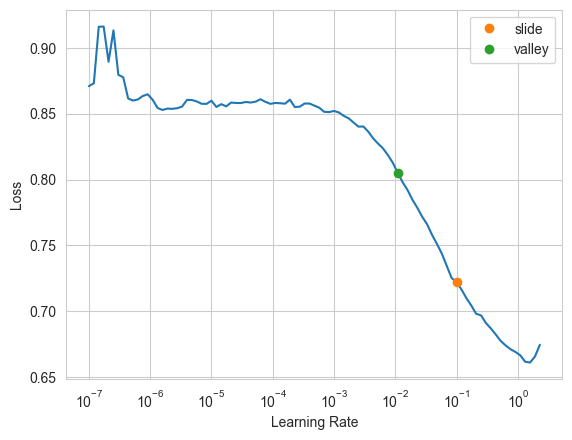

In [161]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
learn.lr_find(suggest_funcs=(slide, valley))

In [165]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.356688,0.412140,0.820225,00:00
1,0.359711,0.424887,0.803371,00:00
2,0.353589,0.421995,0.797753,00:00
3,0.354648,0.436398,0.797753,00:00
4,0.354986,0.490909,0.808989,00:00
5,0.360102,0.461626,0.808989,00:00
6,0.356845,0.480023,0.808989,00:00
7,0.354507,0.465852,0.797753,00:00
8,0.352529,0.445359,0.808989,00:00
9,0.349859,0.450913,0.808989,00:00


### Test DL

In [172]:
tst_df = pd.read_csv(dataset_path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

tst_dl = learn.dls.test_dl(tst_df)

/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


### Ensembling

In [173]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

learns = [ensemble() for _ in range(5)]
ens_preds = torch.stack(learns).mean(0)


tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

!head ens_sub.csv


# How does GPT do EDA? It got a system!

Without historical context or prior knowledge about the Titanic disaster, determining key variables for analysis would rely more heavily on a systematic exploration of the dataset's features and their statistical relationships. Here's how you could approach identifying key variables purely from the data:


### 1. Understanding the Data Structure
Start by examining the dataset to understand what each variable represents and its data type (numerical, categorical, etc.). This step helps identify which variables are potential predictors and which one is the target variable.


### 2. Descriptive Statistics

Calculate descriptive statistics for numerical variables (mean, median, standard deviation, etc.) and frequency counts for categorical variables. This step can help identify variables with significant variance or diversity in values, suggesting potential for meaningful analysis.


### 3. Correlation Analysis
Perform correlation analysis to identify relationships between variables. For numerical variables, Pearson correlation coefficients can give insights into linear relationships, while for categorical variables or a mix of categorical and numerical, techniques like Chi-square tests, ANOVA, or Cramér's V can be used. High correlation with the target variable might indicate key predictors.

### 4. Visual Exploration

Utilize visual tools such as histograms, box plots, and scatter plots to explore the distribution of individual variables and the relationships between them. Visual exploration can reveal patterns, outliers, and potential influential factors that might not be obvious through statistical metrics alone.

    Pairwise Relationships: Scatter plots or pair plots can help visualize relationships between the target variable and potential predictors.
    Distribution of Target Variable Across Groups: Box plots or violin plots for the target variable across different categories can highlight influential categorical predictors.

### 5. Missing Values Analysis

Identify the extent of missing data across variables. A high proportion of missing values might indicate issues with certain variables but can also suggest areas requiring further investigation or potential for feature engineering.

### 6. Preliminary Feature Importance
Even before formal modeling, simple machine learning models (like decision trees) can be applied to the dataset to get an initial estimate of feature importance. This step requires minimal preprocessing and can provide early insights into which variables might be influential.

### 7. Domain Research
In the absence of specific historical context, a bit of research into similar datasets or problems can help identify commonly important variables in similar scenarios. This step isn't about gaining deep historical insight but rather about identifying potentially analogous situations and the variables important in those contexts.
Summary

Focusing on these data-driven approaches provides a structured pathway to identify key variables without relying on external context. This process is iterative, where initial findings might lead you back to earlier steps for a deeper dive, ensuring a comprehensive understanding of the dataset's potential for analysis and modeling.